In [9]:
import sys
import os

fgpgm_root = "/home/dsemchin/Progression_models_simulations/FGPGM-master/FGPGM"
sys.path.append(fgpgm_root)
from Experiment import Experiment

import numpy as np
import matplotlib.pyplot as plt

class LotkaVolterra(Experiment):
    def __init__(self):
        pass
    
    def f(self, x, theta):
        """
        \dot{x_0} = x_0 * (theta_0 - theta_1*x_1)
        \dot{x_1} = -x_1 * (theta_2 - theta_3*x_0)
        will return derivatives in a vector
        """
        firstODE = x[0]*(theta[0] - theta[1]*x[1])
        secondODE = -x[1]*(theta[2] - theta[3]*x[0])
        return np.asarray([firstODE, secondODE])

    def getBounds(self, nStates, nParams, x0=None):
        """
        returns a list of bounds for states and parameters to constrain
        optimization. If standardization is used later on, the bounds on the
        states are for the standardized states, i.e. [-3, 3] on a state
        variable with mean 2 and std 3 will mean bounds of [-7, 11] in original
        coordinates.
        """
        xmin = []
        xmax = []
        for i in np.arange(nStates):
            xmin.append(-3)
            xmax.append(3)
        for i in np.arange(nParams):
            xmin.append(0)
            xmax.append(100)
        return xmin, xmax


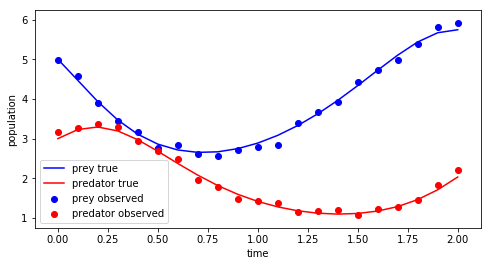

In [10]:
# initial values
XInit = np.asarray([5, 3])  # initial populations
theta = np.asarray([2, 1, 4, 1])  # growth/interaction coefficients

tEnd = 2
dt = 0.1
time = np.arange(0, tEnd+0.5*dt, dt)  # obs time
time = np.asarray(time)

obsStd = 0.1

experiment = LotkaVolterra()
plotPath = None
x, y = experiment.sampleTrajectoryNonUniform(XInit,
                                             theta,
                                             time,
                                             obsNoiseStd=obsStd,
                                             SNR=None,
                                             plotting=plotPath)

plt.figure(figsize=(8, 4))
plt.plot(time, x[:, 0], label="prey true", color='b')
plt.plot(time, x[:, 1], label="predator true", color='r')
plt.scatter(time, y[:, 0], label="prey observed", color='b')
plt.scatter(time, y[:, 1], label="predator observed", color='r')
plt.xlabel("time")
plt.ylabel("population")
plt.legend()
plt.show()

In [11]:
# -*- coding: utf-8 -*-
# Author: Philippe Wenk <philippewenk@hotmail.com>
"""
Creates and saves all the hyperparameters needed by doFGPGM.py. Should only
be run after the experiment has been created using createExperiments.py.
"""
sys.path.append('/home/dsemchin/Progression_models_simulations/FGPGM-master')
os.chdir('/home/dsemchin/Progression_models_simulations/FGPGM-master')
from FGPGM.Kernels.RBF import RBF
from FGPGM.DensityCalculation import getAs, getDs, getLambdaStars, calculateLogDensity

plt.switch_backend('agg')

# decide if the data should be standardized in a preprocessing step
standardize = True

"""kernel optimization"""
# amount of basinhopping iterations in kernel hyperparameter optimization
kernelIter = 100  # should be adjusted based on roughness of likelihood
gammaValue = 3e-1

"""create Kernel and Kernel matrices"""
kernel = RBF(theta=np.abs(np.random.randn(2)),
             sigma=np.abs(np.random.randn(1)))

kernel.learnHyperparams(
    kernel.theta,
    kernel.sigma,
    y,
    time,
    normalize=True,
    standardize=standardize,
    newNugget=1e-4,
    anneal=False,
    basinIter=kernelIter
    )

print("optimal hyperparameters:")
print("gammaValue: ",gammaValue)
print("theta: ", kernel.theta)
print("sigma: ", kernel.sigma)

best_theta = kernel.theta
best_sigma = kernel.sigma


using L-BFGS-B as hyperparameter optimizer
YES: -4.42294757292 @ [1.89952355 0.51457598 0.08716281]
YES: -4.42294757295 @ [1.89947917 0.51457524 0.08716259]
YES: -4.42294757297 @ [1.89949117 0.51457484 0.08716279]
YES: -4.42294757293 @ [1.8995233  0.51457661 0.08716275]
YES: -4.42294757294 @ [1.89946417 0.51457332 0.08716288]
YES: -4.42294757297 @ [1.89948235 0.51457415 0.08716264]
YES: -4.42294757288 @ [1.89944445 0.51457189 0.08716293]
YES: -4.42294757294 @ [1.89951837 0.51457604 0.08716268]
YES: -4.42294757298 @ [1.89948361 0.51457428 0.08716267]
YES: -4.42294757219 @ [1.89938603 0.51456615 0.08716343]
YES: -4.42294757294 @ [1.89945829 0.51457305 0.0871627 ]
Nope: 2.00019216461 @ [1.00000000e-04 9.32438532e+00 9.99995755e-01]
YES: -4.42294757294 @ [1.89947861 0.51457501 0.0871625 ]
YES: -4.42294757298 @ [1.89949193 0.51457465 0.08716265]
YES: -4.42294757298 @ [1.89949007 0.51457457 0.08716268]
YES: -4.42294757295 @ [1.89951205 0.51457556 0.08716265]
YES: -4.42294757297 @ [1.89949336

Use standardization of the observations
break point 0
initialize with GP posterior
0 states needed correction, as they were too close to zero

state acceptance mean with std: 
0.221125 +- 0.0588016553561

state acceptance range: 
0.184 to 0.4135

param acceptance mean with std: 
0.316375 +- 0.139679264299

param acceptance range: 
0.1605 to 0.5095
[2.02609102 0.97390895 3.82587172 0.94298116]


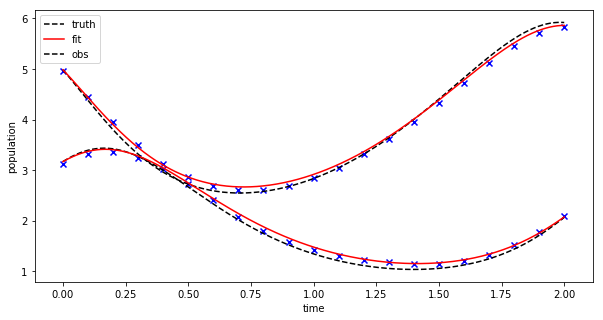

In [15]:
# -*- coding: utf-8 -*-
# Author: Philippe Wenk <philippewenk@hotmail.com>
"""
After experiments have been created using the script createExperiments.py,
this script can be run to infer the ODE parameters using FGPGM.
"""
import numpy as np

from FGPGM.Experiments.LotkaVolterra import LotkaVolterra as exp
from FGPGM.Kernels.RBF import RBF as kernel
from FGPGM.FGPGM import FGPGM

from matplotlib import pyplot as plt
plt.switch_backend('agg')

"""determine standardization"""
if standardize == 0:
    standardize=False
    print("Do not use standardization of the observations")
elif standardize == 1:
    standardize=True
    print("Use standardization of the observations")
else:
    raise ValueError("Illegal value encountered in standardize.csv." +
                     "Maybe the file is corrupted?")

"""experiment and observation loading"""

# create experiment
experiment = exp()
gammas = gammaValue*np.ones(y.shape[1])

"""create kernels using hyperparameters calculated by getHyperparams.py"""
kernels = []
for state in np.arange(y.shape[1]):
    currentKernel = kernel(theta=np.abs(np.random.randn(3)),
                           sigma=np.abs(np.random.randn(1)))
    currentKernel.theta = best_theta
    currentKernel.sigma = best_sigma
    kernels.append(currentKernel)    

"""find initial values for theta"""
trueTheta = theta
theta0 = np.abs(np.random.randn(trueTheta.size))    

"""create FGPGM object"""
FM = FGPGM(kernels=kernels,
           time=time,
           y=y,
           experiment=experiment,
           nODEParams=trueTheta.size,
           gamma=gammas,
           normalize=True,
           standardize=standardize)

"""perform actual parameter estimation minimization"""
stateStds = np.ones(y.size)*0.075
paramStds = np.ones(theta0.size)*0.09
propStds = np.concatenate([stateStds, paramStds])
print("break point 0")

newStates, newParams = FM.getFGPGMResults(GPPosteriorInit=True,
                                          blockNegStates=False,
                                          debug=True,
                                          theta0=theta0,
                                          thetaMagnitudes=np.zeros_like(theta0),
                                          nSamples=3000,
                                          nBurnin=1000,
                                          propStds=propStds)

print(newParams)

# np.savetxt("optimalParamsFGPGM.csv", newParams)
# np.savetxt("optimalStatesFGPGM.csv", newStates)
# print(newParams)

"""Visualizing the results"""
tEnd = time[-1]
timeDense = np.linspace(0, tEnd, 500)
XInit = y[0, :]  # Use first observed values as initial conditions

xDenseTrue = experiment.sampleTrajectoryNonUniform(XInit, trueTheta, timeDense, obsStd)[0]
xDenseNew = experiment.sampleTrajectoryNonUniform(XInit, newParams, timeDense, obsStd)[0]

plt.figure(figsize=(10, 5))
for i in range(xDenseNew.shape[1]):
    plt.plot(timeDense, xDenseTrue[:, i], 'k', linestyle="dashed")
    plt.plot(timeDense, xDenseNew[:, i], 'r')
    plt.scatter(time, newStates[:, i], marker='x', c='b')
    plt.xlabel("time")
    plt.ylabel("population")
    plt.legend(["truth", "fit", "obs"])
    plt.show()